In [1]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.metrics import roc_auc_score, precision_score, log_loss, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
def model_rf_gcv(X, y, estimators):
    start = time.time()
    scorer = {'log_loss': metrics.make_scorer(log_loss, needs_proba = True),
              'precision':metrics.make_scorer(precision_score),
              'roc_auc':metrics.make_scorer(roc_auc_score)}
    kf = KFold(n_splits = 5, shuffle = True)
    parameters = {'n_estimators': [estimators], 'max_depth': [60], 'min_samples_leaf': [20]}
    gcv = GridSearchCV(estimator = RandomForestClassifier(), param_grid = parameters, 
                       scoring = scorer, refit = 'roc_auc', n_jobs = -1, cv = kf)
    gcv.fit(X, y)
    end = time.time()
    print('Time %d:%d:%f' %(round((end - start)//3600),round((end - start)//60),(end - start) % 60))
    return gcv


def tfidf(X_train, X_test, max_features):
    tfidf_word = TfidfVectorizer(
        analyzer='word',
        max_df = 0.1, 
        ngram_range=(1, 2),
        max_features=max_features)
    tfidf_X = tfidf_word.fit_transform(X['comment_text'])
    tfidf_test_X = tfidf_word.transform(test_X['comment_text'])
    return tfidf_X, tfidf_test_X, tfidf_word

In [3]:
train = pd.read_csv('../datasets/processed_train.csv', index_col='id')
test_X = pd.read_csv('../datasets/processed_test.csv', index_col='id')
test_y = pd.read_csv('../datasets/test_labels.csv', index_col='id')
X = train[['comment_text']]  
y = train[['toxic']] 

In [4]:
estimators = [i*20 for i in range(1, 11)]

In [5]:
max_features = 40000
tfidf_X, tfidf_test_X, model_tfidf = tfidf(X, test_X, max_features)

In [6]:
#0 - log_loss, 1 - precision, 2 - roc_auc
cv_score = []
test_score = []
features = []
for i in estimators:
    print('%d:' % i)
    rf = model_rf_gcv(tfidf_X, y, i)
    features.append(rf.best_estimator_.feature_importances_)
    pred_y = rf.predict(tfidf_test_X)
    pred_proba = rf.predict_proba(tfidf_test_X)
    cv_score.append({0:rf.cv_results_['mean_test_log_loss'][0],
                     1:rf.cv_results_['mean_test_precision'][0],
                     2:rf.cv_results_['mean_test_roc_auc'][0]})
    test_score.append({0:log_loss(test_y, pred_proba),
                       1:precision_score(test_y, pred_y),
                       2:roc_auc_score(test_y, pred_y)})
    

20:
Time 0:0:9.845136
40:
Time 0:0:18.358715
60:
Time 0:0:27.026644
80:
Time 0:0:36.794747
100:
Time 0:0:46.695155
120:
Time 0:0:51.284080
140:
Time 0:1:4.217320
160:
Time 0:1:12.578690
180:
Time 0:1:23.047448
200:
Time 0:1:23.250754


Text(0.5, 1.0, 'Логистическая функция потерь')

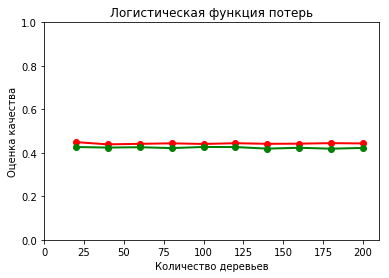

In [7]:
plt.plot(estimators,[x[0] for x in cv_score],  'go-', 
         label='line 1', linewidth = 2, color = 'red')
plt.plot(estimators, [x[0] for x in test_score],  'go-', 
         label='line 1', linewidth = 2, color = 'green')
plt.ylim(0, 1)
plt.xlim(0, 20*len(estimators) + 10)
plt.ylabel('Оценка качества')
plt.xlabel('Количество деревьев')
plt.title('Логистическая функция потерь')

Text(0.5, 1.0, 'Точность')

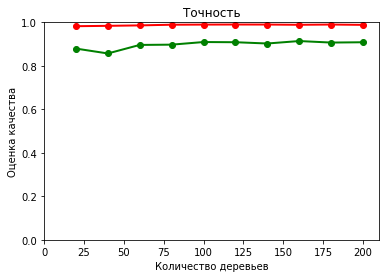

In [8]:
plt.plot(estimators,[x[1] for x in cv_score],  'go-', 
         label='line 1', linewidth = 2, color = 'red')
plt.plot(estimators, [x[1] for x in test_score],  'go-', 
         label='line 1', linewidth = 2, color = 'green')
plt.ylim(0, 1)
plt.xlim(0, 20*len(estimators) + 10)
plt.ylabel('Оценка качества')
plt.xlabel('Количество деревьев')
plt.title('Точность')

Text(0.5, 1.0, 'ROC-AUC')

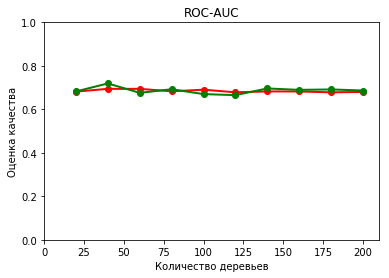

In [9]:
plt.plot(estimators,[x[2] for x in cv_score],  'go-', 
         label='line 1', linewidth = 2, color = 'red')
plt.plot(estimators, [x[2] for x in test_score],  'go-', 
         label='line 1', linewidth = 2, color = 'green')
plt.ylim(0, 1)
plt.xlim(0, 20*len(estimators) + 10)
plt.ylabel('Оценка качества')
plt.xlabel('Количество деревьев')
plt.title('ROC-AUC')

In [10]:
cv_scores = pd.DataFrame( index=estimators, columns=['ROC-AUC', 'Precision', 'Log loss'])
cv_scores['ROC-AUC'] = [round(x[2], 6) for x in cv_score]
cv_scores['Log loss'] =  [round(x[0], 6) for x in cv_score]
cv_scores['Precision'] =  [round(x[1], 6) for x in cv_score]
cv_scores.to_csv('scores_cv.csv')

In [11]:
test_scores = pd.DataFrame( index=estimators, columns=['ROC-AUC', 'Precision', 'Log loss'])
test_scores['ROC-AUC'] = [round(x[2], 6) for x in test_score]
test_scores['Log loss'] =  [round(x[0], 6) for x in test_score]
test_scores['Precision'] =  [round(x[1], 6) for x in test_score]
test_scores.to_csv('scores_test.csv')

In [12]:
features_imp = []
features_ = features[9] 

for word, idx in model_tfidf.vocabulary_.items():
    if features_[idx]>0:
        features_imp.append((features_[idx], word))

sorted(features_imp, key = lambda x: x[0])
features_imp = list(map(lambda x: x[1], features_imp))
features_imp[:200]

['octob',
 'engag',
 'war',
 'revert',
 'revers',
 'singl',
 'period',
 'adit',
 'perform',
 'larg',
 'content',
 'disput',
 'block',
 'technic',
 'violat',
 'rule',
 'continu',
 'repeat',
 'word',
 'consensus',
 'editor',
 'resolut',
 'edit war',
 'block edit',
 'revert rule',
 'continu block',
 'revert edit',
 'infobox',
 'document',
 'format',
 'stand',
 'fine',
 'present',
 'liter',
 'eror',
 'put',
 'citat',
 'requir',
 'statement',
 'controversi',
 'sili',
 'preti',
 'grace',
 'god',
 'lame',
 'latest',
 'final',
 'releas',
 'album',
 'write',
 'end',
 'back',
 'distinct',
 'atempt',
 'british',
 'schol',
 'ident',
 'world',
 'univers',
 'debat',
 'acur',
 'understand',
 'style',
 'john',
 'memori',
 'run',
 'speak',
 'mention',
 'conduct',
 'section',
 'object',
 'joke',
 'folow',
 'tel',
 'person',
 'atack',
 'cher',
 'person atack',
 'mental',
 'status',
 'stori',
 'septemb',
 'year',
 'shot',
 'kil',
 'ofici',
 'report',
 'finish',
 'file',
 'state',
 'product',
 'suport',
 '